# ¿Ha disminuido la concetración de gases tras las restricciones de Madrid Central? 

## Descripción del problema

<img src="madrid_central.png" style="float:right; width: 300px"></img>
El Ayuntamiento de Madrid pone a disposición del ciudadano un catálogo de datos abiertos sobre la ciudad madrileña. 

Utilizando los datos referentes a la [Calidad del Aire](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=f3c0f7d512273410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)  queremos estudiar si tras las restricciones de tráfico llevadas a cabo en Madrid Central realmente ha disminuido la concentración de Dióxido de Nitrógeno (NO2).

Para ello queremos analizar cómo ha variado la presencia de NO2 en las mediciones realizadas por las estaciones de calidad del aire dentro de Madrid Central, en torno a la fecha en la que se activaron por primera vez las restricciones.

## Análisis

### Generación del dataset

Considerando que Madrid Central entró en vigor el **30 de Noviembre de 2018**, genera el dataset de partida a través de los datos que facilita el Ayuntamiento de Madrid: [Calidad del aire. Datos horarios años 2001 a 2021](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=f3c0f7d512273410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)

El dataset debe tener en cuenta las siguientes consideraciones:
* nos interesa la zona de Madrid Central, por lo que, sólo debe contener información de aquellas estaciones que se ubiquen dentro de este área. Para este punto puedes apoyarte en los ficheros adicionales de la carpeta `Estaciones`.
* nuestro análisis está centrado en el Dióxido de Nitrógeno, pero también queremos ver la relación con otros gases como: Monóxido de Carbono (CO), Monóxido de Nitrógeno (NO) y Óxidos de Nitrógeno (NOx). Así que podemos reducir el dataset a estas magnitudes.
* partimos del dato diario a nivel horario.

In [1]:
import pandas as pd                             # Lee el archivo csv
from shapely.geometry import Point, Polygon     # Convierte latitud/longitud en geometría 
import geopandas as gpd                         # Crea el GeodataFrame
import matplotlib.pyplot as plt                 # Visualiza gráficamente

# Configuro la ruta del archivo a leer
fp = 'estaciones/madrid_central/madrid_central.shp'
fp2 = 'estaciones/estaciones.csv'

# Leo el archivo que contiene el polígono de Madrid Central
mcentral = gpd.read_file(fp)
df = pd.read_csv(fp2, encoding= "latin_1", delimiter=";")

In [2]:
df.head()

,CODIGO,CODIGO_CORTO,ESTACION,DIRECCION,LONGITUD_ETRS89,LATITUD_ETRS89,ALTITUD,COD_TIPO,NOM_TIPO,NO2,...,HC,COD_VIA,VIA_CLASE,VIA_PAR,VIA_NOMBRE,Fecha alta,COORDENADA_X_ETRS89,COORDENADA_Y_ETRS89,LONGITUD,LATITUD
0,28079004,4,Pza. de España,Plaza de España,"3°42'43.91""O","40°25'25.98""N",637,UT,Urbana tráfico,X,...,NaN,273600,PLAZA,DE,ESPAÑA,01/12/1998,"439579,3291","4475049,263",-3.712257,40.423882
1,28079008,8,Escuelas Aguirre,Entre C/ Alcalá y C/ O Donell,"3°40'56.22""O","40°25'17.63""N",672,UT,Urbana tráfico,X,...,X,18900,CALLE,DE,ALCALA,01/12/1998,"442117,2366","4474770,696",-3.682316,40.421553
2,28079011,11,Avda. Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,"3°40'38.50""O","40°27'5.29""N",708,UT,Urbana tráfico,X,...,NaN,610450,CALLE,DEL,PRINCIPE DE VERGARA,01/12/1998,"442564,0457","4478088,595",-3.677349,40.451473
3,28079016,16,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,"3°38'21.17""O","40°26'24.20""N",695,UF,Urbana fondo,X,...,NaN,798700,CALLE,DEL,VIZCONDE DE LOS ASILOS,01/12/1998,"445786,1729","4476796,019",-3.639242,40.440046
4,28079017,17,Villaverde,C/. Juan Peñalver,"3°42'47.89""O","40°20'49.74""N",601,UF,Urbana fondo,X,...,NaN,417200,CALLE,DE,JUAN PEÑALVER,01/12/1998,"439420,7015","4466532,455",-3.713317,40.347147


In [3]:
# Comienzo con el perímetro de Madrid Central, alojado en Madrid_Central.shp:

# compruebo el CRS (Coordinate Reference System) del shapefile. 
mcentral.crs

<Projected CRS: EPSG:25830>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°W and 0°W: Faroe Islands offshore; Ireland - offshore; Jan Mayen - offshore; Norway including Svalbard - offshore; Spain - onshore and offshore.
- bounds: (-6.0, 35.26, 0.01, 80.49)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
for e in (mcentral["geometry"]):
    print(e)

LINESTRING (441388.762008 4475170.169531, 441385.561851 4475158.175555, 441316.441274 4474965.293166, 441177.182511 4474579.827087, 441177.1825110001 4474579.827087, 441171.9108954115 4474574.17883427, 441167.0206525775 4474568.197344921, 441162.53279524366 4474561.908320642, 441158.46660715644 4474555.338784566, 441154.83956020407 4474548.516965144, 441151.6672393414 4474541.47217486, 441148.96327562386 4474534.23468427, 441146.73928763636 4474526.835591944, 441145.00483156956 4474519.306690832, 441143.76736015856 4474511.680331653, 441143.0321906591 4474503.989283894, 441142.802482 4474496.266595, 441141.239754 4474484.292181, 441063.325514 4474135.098074, 441060.128303 4474112.289932, 441060.1283029998 4474112.289932, 441079.3004685006 4474067.82882096, 441096.00368699984 4474022.382536, 441162.086249 4473803.639151, 441174.756909 4473758.816721, 441216.357918 4473581.91812, 441252.654027 4473435.501393, 441263.682162 4473386.38749, 441262.057077 4473377.774114, 441178.406939 447324

In [5]:
# Convierto la LineString en Polygon, para poder analizar si algún punto está dentro del mismo:
line = mcentral.geometry[0]
poligono = Polygon(line)

In [6]:
# Voy a trabajar con las coordenadas de las estaciones de medición:
# Selecciono las columnas que me interesan
subset = ["CODIGO_CORTO", "COORDENADA_X_ETRS89", "COORDENADA_Y_ETRS89"]
coord = df[subset]
coord.head()

,CODIGO_CORTO,COORDENADA_X_ETRS89,COORDENADA_Y_ETRS89
0,4,"439579,3291","4475049,263"
1,8,"442117,2366","4474770,696"
2,11,"442564,0457","4478088,595"
3,16,"445786,1729","4476796,019"
4,17,"439420,7015","4466532,455"


In [7]:
# Consulto el tipo de dato que es
type(coord["COORDENADA_X_ETRS89"][2])

str

In [8]:
# Para convertir el string en float, ustituyo "," por "." y lo hago float
coord["COORDENADA_X_ETRS89"] = coord["COORDENADA_X_ETRS89"].apply(lambda x: float(x.replace(",",".")))
coord["COORDENADA_Y_ETRS89"] = coord["COORDENADA_Y_ETRS89"].apply(lambda x: float(x.replace(",",".")))

/var/folders/bk/rt0l45c51cx59_sxf27vjfhm0000gn/T/ipykernel_47564/837173704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coord["COORDENADA_X_ETRS89"] = coord["COORDENADA_X_ETRS89"].apply(lambda x: float(x.replace(",",".")))
/var/folders/bk/rt0l45c51cx59_sxf27vjfhm0000gn/T/ipykernel_47564/837173704.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coord["COORDENADA_Y_ETRS89"] = coord["COORDENADA_Y_ETRS89"].apply(lambda x: float(x.replace(",",".")))


In [9]:
# Compruebo que es correcto
coord.head()

,CODIGO_CORTO,COORDENADA_X_ETRS89,COORDENADA_Y_ETRS89
0,4,439579.3291,4475049.263
1,8,442117.2366,4474770.696
2,11,442564.0457,4478088.595
3,16,445786.1729,4476796.019
4,17,439420.7015,4466532.455


In [10]:
# Creo una columna de geometría con longitud y latitud
geometry = [Point(xy) for xy in zip(coord['COORDENADA_X_ETRS89'], coord['COORDENADA_Y_ETRS89'])]

# asigno un CRS (el mismo del archivo .shx) : 
crs = {'init': 'epsg:25830'}

# creo un GeodataFrame
gdf = gpd.GeoDataFrame(coord, crs=crs, geometry=geometry)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [11]:
gdf.head()

,CODIGO_CORTO,COORDENADA_X_ETRS89,COORDENADA_Y_ETRS89,geometry
0,4,439579.3291,4475049.263,POINT (439579.329 4475049.263)
1,8,442117.2366,4474770.696,POINT (442117.237 4474770.696)
2,11,442564.0457,4478088.595,POINT (442564.046 4478088.595)
3,16,445786.1729,4476796.019,POINT (445786.173 4476796.019)
4,17,439420.7015,4466532.455,POINT (439420.702 4466532.455)


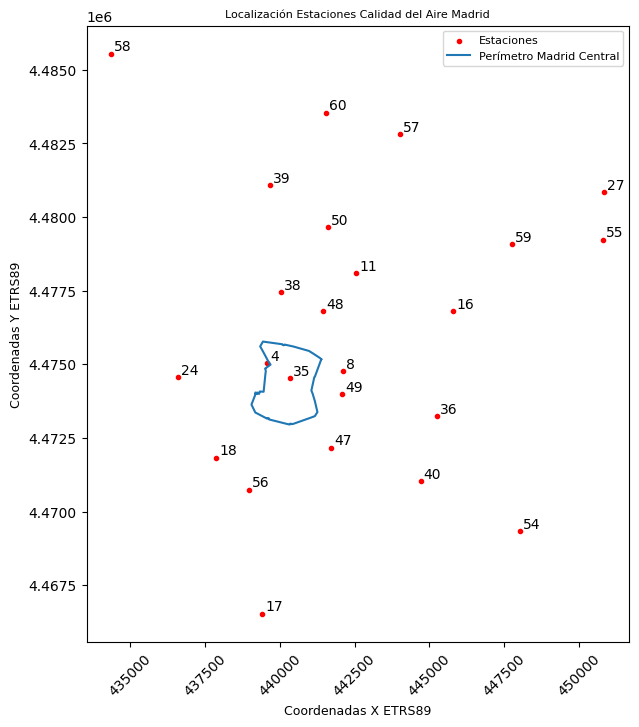

In [12]:
# Los puntos de estaciones y etiquetas:
x = [point.x for point in gdf.geometry]
y = [point.y for point in gdf.geometry]
t = gdf.CODIGO_CORTO

# El perímetro de Madrid Central:
xs, ys = poligono.exterior.xy

# Creo la figura y los ejes
fig, ax = plt.subplots(figsize=(7,8))

# Scatter plot de las estaciones
ax.scatter(x,y , marker='.', c="red", label="Estaciones")

# Plot del perímetro del polígono
ax.plot(xs, ys, label="Perímetro Madrid Central")

# Añado etiquetas a las estaciones
for i, txt in enumerate(t):
    ax.annotate(txt, (x[i]+100, y[i]+100))

# Título y leyenda
ax.set_title('Localización Estaciones Calidad del Aire Madrid', fontsize=8)
ax.legend(fontsize=8)

# Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=45)

# Etiquetas de los ejes
ax.set_xlabel('Coordenadas X ETRS89', fontsize='9')
ax.set_ylabel('Coordenadas Y ETRS89', fontsize='9')

plt.show()

In [13]:
# Aparentemente, la estación 35 es la única dentro de Madrid Central.
# Compruebo todas:

e_mcentral = []

for punto in gdf.geometry:
    if punto.within(poligono):
        estacion = gdf.CODIGO_CORTO[(gdf['geometry'] == punto)].tolist()
        e_mcentral.append(estacion[0])
        print(f"La estación {estacion[0]}, {punto}, está dentro de Madrid Central.")


La estación 35, POINT (440346.3619 4474524.357), está dentro de Madrid Central.


In [14]:
import os
from zipfile import ZipFile

# FUNCIONES UTILIZADAS POSTERIORMENTE

# Función que devuelve una lista de nombres de archivos de una extensión concreta.
def buscador(path, extension):
    contenido = os.listdir(path)
    encontrados = []
    for archivo in contenido:
        if os.path.isfile(os.path.join(path, archivo)) and archivo.endswith(f'.{extension}'):
            encontrados.append(archivo)
    return(encontrados)


# Función que extrae los .csv del .zip:
def unziper(path, file):
    new_path = f'{path}/{file}'
    with ZipFile(new_path, "r") as f:
            dest_dir = f"{path}/unziped_CSV_{file[6:8]}"
            os.mkdir(dest_dir)
            for name in f.namelist():
                if name.endswith(".csv"):
                    f.extract(name, path = dest_dir)


# Función que extrae de cada csv solo las filas de las estaciones que quiero
# filtrando por gases(lista) y estaciones(lista):
def filtro(path, file, gases, estaciones):
    df = pd.read_csv(f'{path}/{file}', encoding= "latin_1", delimiter=";")
    print("csv leído")

    df_selec = df.loc[(df["ESTACION"].isin (estaciones)) & (df['MAGNITUD'].isin(gases))]
    name_out = f'filt_{file[-6:]}'
    path_out = f'datos/horarios/filtrados/{name_out}'

    df_selec.to_csv(path_out, sep=';', index=False)
    print(f"Archivo {name_out} generado")  


In [15]:
# Obtengo una lista de archivos .zip: 

path = "datos/horarios"
ext = "zip"
zip_files = buscador(path, ext)

In [16]:
# Extraigo todos los .csv de los .zip
for e in zip_files:
    unziper(path, e)

In [17]:
path = "datos/horarios"

# Obtengo los nombres de carpetas del directorio
contenido = os.listdir(path)
carpetas = []
for carpeta in contenido:
    if os.path.isdir(os.path.join(path, carpeta)):
        carpetas.append(carpeta)

In [18]:
path = 'datos/horarios/unziped_CSV_01/abr_mo01.csv'
muestra = pd.read_csv(path, delimiter=';')
muestra

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,4,1,28079004_1_38,2001,4,1,20.0,V,...,9.0,V,11.0,V,18.0,V,27.0,V,34.0,V
1,28,79,4,1,28079004_1_38,2001,4,2,17.0,V,...,12.0,V,14.0,V,15.0,V,13.0,V,11.0,V
2,28,79,4,1,28079004_1_38,2001,4,3,11.0,V,...,9.0,V,10.0,V,11.0,V,10.0,V,9.0,V
3,28,79,4,1,28079004_1_38,2001,4,4,8.0,V,...,10.0,V,10.0,V,10.0,V,9.0,V,8.0,V
4,28,79,4,1,28079004_1_38,2001,4,5,8.0,V,...,9.0,V,9.0,V,11.0,V,13.0,V,14.0,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,28,79,40,12,28079040_12_8,2001,4,26,35.0,V,...,91.0,V,99.0,V,137.0,V,186.0,V,163.0,V
2075,28,79,40,12,28079040_12_8,2001,4,27,117.0,V,...,38.0,V,42.0,V,61.0,V,56.0,V,44.0,V
2076,28,79,40,12,28079040_12_8,2001,4,28,40.0,V,...,30.0,V,49.0,V,99.0,V,101.0,V,143.0,V
2077,28,79,40,12,28079040_12_8,2001,4,29,130.0,V,...,23.0,V,39.0,V,61.0,V,49.0,V,33.0,V


In [19]:
# CSV ANUALES COMBINADOS:

# Accedo a cada carpeta
path = "datos/horarios"
out = f'{path}/combinados'
# Creo carpeta donde guardar todos los csv combinados
os.mkdir(out)
for carpeta in carpetas:
    carpeta_path = f'{path}/{carpeta}'
    # listo los csv que hay
    csv_files = buscador(carpeta_path, extension="csv")
    # los combino y exporto
    csv_combinado = pd.concat([pd.read_csv(f'{carpeta_path}/{f}', delimiter=';') for f in csv_files])
    csv_combinado.to_csv(f"{out}/comb_csv_{carpeta[-2:]}.csv", sep=';', index=False)


In [20]:
path = 'datos/horarios/unziped_CSV_01/abr_mo01.csv'
testeo = pd.read_csv(path, delimiter=";")
testeo.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,4,1,28079004_1_38,2001,4,1,20.0,V,...,9.0,V,11.0,V,18.0,V,27.0,V,34.0,V
1,28,79,4,1,28079004_1_38,2001,4,2,17.0,V,...,12.0,V,14.0,V,15.0,V,13.0,V,11.0,V
2,28,79,4,1,28079004_1_38,2001,4,3,11.0,V,...,9.0,V,10.0,V,11.0,V,10.0,V,9.0,V
3,28,79,4,1,28079004_1_38,2001,4,4,8.0,V,...,10.0,V,10.0,V,10.0,V,9.0,V,8.0,V
4,28,79,4,1,28079004_1_38,2001,4,5,8.0,V,...,9.0,V,9.0,V,11.0,V,13.0,V,14.0,V


In [21]:
# VOY A FILTRAR CADA COMBINADO:

# Creo carpeta donde guardar todos los csv filtrados
out_filtr = 'datos/horarios/filtrados'
os.mkdir(out_filtr)

# Accedo a combinados
carpeta_comb = 'datos/horarios/combinados'
# Listo los csv que hay
csv_comb_files = buscador(carpeta_comb, extension="csv")
print(csv_comb_files)

['comb_csv_10.csv', 'comb_csv_04.csv', 'comb_csv_05.csv', 'comb_csv_11.csv', 'comb_csv_07.csv', 'comb_csv_13.csv', 'comb_csv_12.csv', 'comb_csv_06.csv', 'comb_csv_02.csv', 'comb_csv_16.csv', 'comb_csv_17.csv', 'comb_csv_03.csv', 'comb_csv_15.csv', 'comb_csv_01.csv', 'comb_csv_14.csv', 'comb_csv_19.csv', 'comb_csv_18.csv', 'comb_csv_20.csv', 'comb_csv_08.csv', 'comb_csv_09.csv', 'comb_csv_21.csv']


In [22]:
# establezco los filtros de gases y estaciones:
path = f'datos/horarios/combinados/'
gases = [8,6,7,12]
estaciones = e_mcentral

# filtro todos los csv combinados:
for e in csv_comb_files:
    filtro (path, e, gases, estaciones)

csv leído
Archivo filt_10.csv generado
csv leído
Archivo filt_04.csv generado
csv leído
Archivo filt_05.csv generado
csv leído
Archivo filt_11.csv generado
csv leído
Archivo filt_07.csv generado
csv leído
Archivo filt_13.csv generado
csv leído
Archivo filt_12.csv generado
csv leído
Archivo filt_06.csv generado
csv leído
Archivo filt_02.csv generado
csv leído
Archivo filt_16.csv generado
csv leído
Archivo filt_17.csv generado
csv leído
Archivo filt_03.csv generado
csv leído
Archivo filt_15.csv generado
csv leído
Archivo filt_01.csv generado
csv leído
Archivo filt_14.csv generado
csv leído
Archivo filt_19.csv generado
csv leído
Archivo filt_18.csv generado
csv leído
Archivo filt_20.csv generado
csv leído
Archivo filt_08.csv generado
csv leído
Archivo filt_09.csv generado
csv leído
Archivo filt_21.csv generado


In [23]:
# COMBINO CSV FILTRADOS:

# Accedo a filtrados
carpeta_filt = 'datos/horarios/filtrados'

# Listo los csv que hay
csv_filt_files = buscador(carpeta_filt, extension="csv")

# Accedo a la carpeta de filtrados:
path = 'datos/horarios/filtrados'
out = 'datos/horarios'

# los combino y exporto:
csv_final = pd.concat([pd.read_csv(f'{path}/{f}', delimiter=';') for f in csv_filt_files])
csv_final.to_csv(f"{out}/data.csv", sep=';', index=False)


In [24]:
# compruebo que los datos son de la estación y los gases que quiero analizar
data = 'datos/horarios/data.csv'
df = pd.read_csv(data, sep=';')
df.value_counts()

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO  ANO   MES  DIA  H01    V01  H02    V02  H03    V03  H04    V04  H05    V05  H06   V06  H07   V07  H08    V08  H09    V09  H10    V10  H11    V11  H12    V12  H13    V13  H14    V14  H15    V15  H16    V16  H17    V17  H18    V18  H19    V19  H20    V20  H21    V21  H22    V22  H23    V23  H24    V24
28         79         35        6         28079035_6_48   2001  1    1    0.9    V    1.3    V    2.3    V    1.8    V    1.1    V    0.5   V    0.4   V    0.4    V    0.4    V    0.4    V    0.3    V    0.3    V    0.3    V    0.4    V    0.5    V    0.5    V    0.4    V    0.4    V    0.6    V    0.6    V    0.5    V    0.4    V    0.4    V    0.2    V      1
                                8         28079035_8_8    2014  12   14   39.0   V    35.0   V    39.0   V    31.0   V    33.0   V    34.0  V    35.0  V    28.0   V    37.0   V    47.0   V    50.0   V    60.0   V    62.0   V    65.0   V    75.0   V    69.0   V    67.0   V    7

### Estudio del efecto inmediato de Madrid Central

Para analizar los efectos inmediatos de las restricciones, empezamos por representar de manera **gráfica** la serie temporal de **Dióxido de Nitrógeno**. Marca en la gráfica la entrada en vigor de la normativa de Madrid Central para facilitar el estudio.

In [25]:
# Me quedo son con la magnitud que representa el NO2 y quito la columna:
df_no2 = df.loc[df['MAGNITUD']==8]
columnas = ['PROVINCIA', 'MAGNITUD', 'MUNICIPIO', 'ESTACION', 'PUNTO_MUESTREO']
df_no2 = df_no2.drop(columnas, axis=1)

# Y ordeno por fecha:
df_no2 = df_no2.sort_values(['ANO', 'MES', 'DIA'])

# Creo una columna de fecha utilizando las columnas 'año', 'mes', 'día'
df_no2 = df_no2.rename(columns={'ANO': 'YEAR', 'MES': 'MONTH', 'DIA': 'DAY' })
df_no2['fecha'] = pd.to_datetime(df_no2[['YEAR', 'MONTH', 'DAY']])

In [26]:
# Creo una lista con las columnas de hora
columnas_hora = [f'H{i:02}'.format(i) for i in range(1, 25)]

In [27]:
# Selecciono solo las columnas de fecha y hora
df_no2 = df_no2[['fecha'] + columnas_hora]

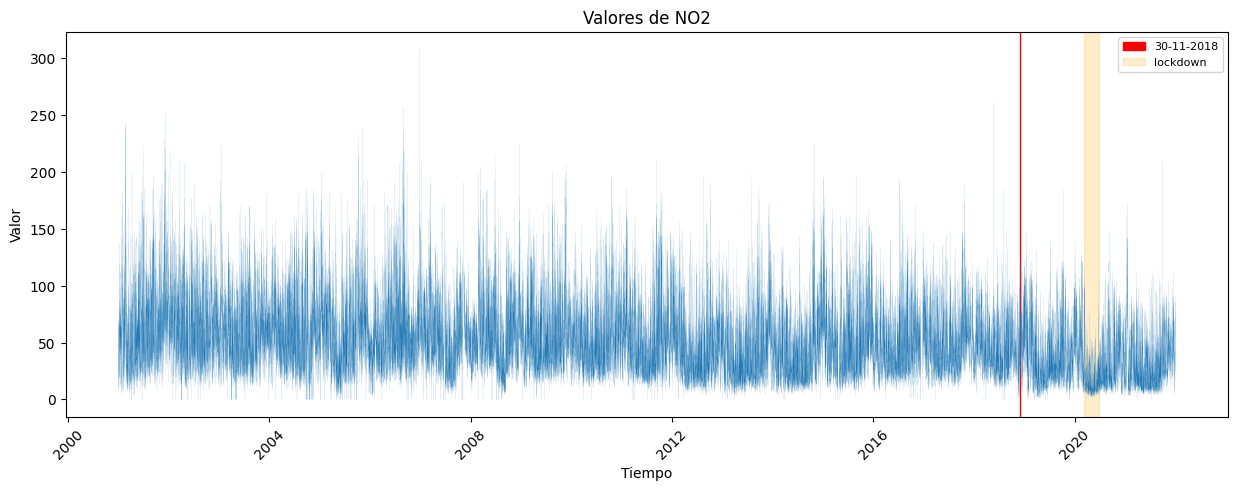

In [28]:
# Convierto el df en formato "largo" utilizando .melt 
df_no2 = df_no2.melt(id_vars='fecha', value_vars=columnas_hora, var_name='hora', value_name='valor')

# Y lo ordeno por fecha y hora
df_no2 = df_no2.sort_values(['fecha', 'hora'])

# Creo el gráfico
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_no2['fecha'], df_no2['valor'], linewidth=0.04)
ax.axvspan('2018-11-30','2018-12-01', color='red', label='30-11-2018')
ax.axvspan('2020-03-11','2020-06-26', color='orange', alpha=0.2, label='lockdown')

# Ejes
ax.set_xlabel('Tiempo')
ax.set_ylabel('Valor')
ax.set_title('Valores de NO2')

# Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=45)
ax.legend(fontsize=8)

# Mostrar el gráfico
plt.show()

Para analizar mejor los resultados, representa también **cómo varia la emisión media diaria de este gas frente al año anterior** a lo largo del tiempo.

In [29]:
# Calculo los valores medios diarios
df_no2_mean_day = df_no2.groupby('fecha').mean(numeric_only=True)

# Calculo los valores medios diarios del año anterior
df_no2_mean_day_prev = df_no2_mean_day.shift(365)

# Calculo la diferencia de los valores medios frente al año anterior (en porcentaje)
df_variacion = (df_no2_mean_day - df_no2_mean_day_prev)/df_no2_mean_day_prev * 100


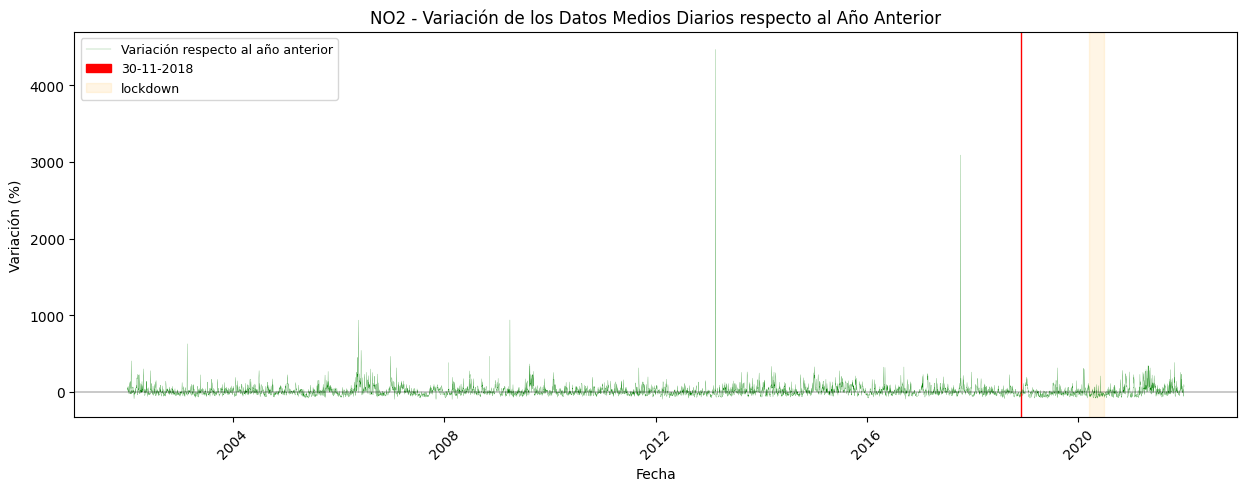

In [30]:
# Creo el gráfico de línea:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_variacion.index, df_variacion['valor'], color='green', label='Variación respecto al año anterior',linewidth=0.15)
ax.axvspan('2018-11-30','2018-12-01', color='red', label='30-11-2018')
ax.axvspan('2020-03-11','2020-06-26', color='orange', alpha=0.1, label='lockdown')

# Etiquetas y título: 
ax.set_xlabel('Fecha')
ax.set_ylabel('Variación (%)')
ax.set_title('NO2 - Variación de los Datos Medios Diarios respecto al Año Anterior')

# Etiquetas a 45º:
plt.xticks(rotation=45)
plt.axhline(y=0, color="black", linewidth=0.3)

# Leyenda
ax.legend(fontsize=9)

# Mostrar el gráfico
plt.show()

**¿Qué conclusiones sacas tras este primer análisis?** 
* ¿Realmente ha disminuido la concentración del NO2 tras la aplicación de Madrid Central? 
* ¿Utilizarías algún otro gráfico para mostrar los resultados? En caso afirmativo, muéstralo.

<span style="color:#FFD8A7 ">

Habría que revisar los datos. Parece haber algunos excepcionalmente altos, tal vez "outliers".  
Es dificil saber si la concentración de NO2 ha disminuido tras la aplicación de Madrid Central (MC).  
Este primer análisis es incompleto, puesto que a nivel gráfico no da mucha información relevante y sería necesario apoyarse no solo en la gráfica sino en análisis estadísticos de los propios datos.  
Por ejemplo: Sería interesante saber el número total de días cuya media es significativamente menor que el año anterior.  
Por otra parte, contar con una sola estación dentro de Madrid Central limita la posibilidad de sacar conclusiones extrapolables.
  
Utilizar la única estación que está dentro de MC, es asumir que va a ser la más afectada (y representativa) por la medida,  
como si las causas y consecuencias de la aplicación de MC no pudiesen cruzar la frontera (imaginaria) del perímetro MC.

Es posible que la zona que haya notado un mayor descenso de la concentración del NO2 no esté en el centro geométrico del polígono contenido por Madrid Central,  
debido a múltiples factores:
- desplazamiento de los gases por viento.
- temperatura, humedad, precipitaciones.
- permanencia de los gases en el tiempo tras la desaparición de los emisores.
- distribución inconsistente de tráfico dentro y fuera de Madrid Central, antes y después de la aplicación de la medida.
- la propia geometría urbana (edificios, avenidas, etc...)
- fuente de emisiones complementaria a vehículos motorizados, por ejemplo: construcción.

También sería interesante a la hora de entender el fenómeno, comparar con los datos de otras estaciones, cuyos valores medios han podido aumentar/disminuir tras la medida.  
O realizar una representación gráfica de malla georeferenciada que dé una "visión más integral" de la ciudad como un ente mayor y complejo.

</span>


Con respecto al resto de gases que comentábamos al inicio: CO, NO y NOx, **¿ha habido un descenso a nivel anual en la emisión media de los gases entre los años 2018 y 2021?**

In [31]:
# Me quedo son con la magnitud que representa el CO y quito la columna:
df_co = df.loc[df['MAGNITUD']==6]
columnas = ['PROVINCIA', 'MAGNITUD', 'MUNICIPIO', 'ESTACION', 'PUNTO_MUESTREO']
df_co = df_co.drop(columnas, axis=1)

# Y ordeno por fecha:
df_co = df_co.sort_values(['ANO', 'MES', 'DIA'])

# Creo una columna de fecha utilizando las columnas 'año', 'mes', 'día'
df_co = df_co.rename(columns={'ANO': 'YEAR', 'MES': 'MONTH', 'DIA': 'DAY' })
df_co['fecha'] = pd.to_datetime(df_co[['YEAR', 'MONTH', 'DAY']])

# Selecciono solo las columnas de fecha y hora
df_co = df_co[['fecha'] + columnas_hora]

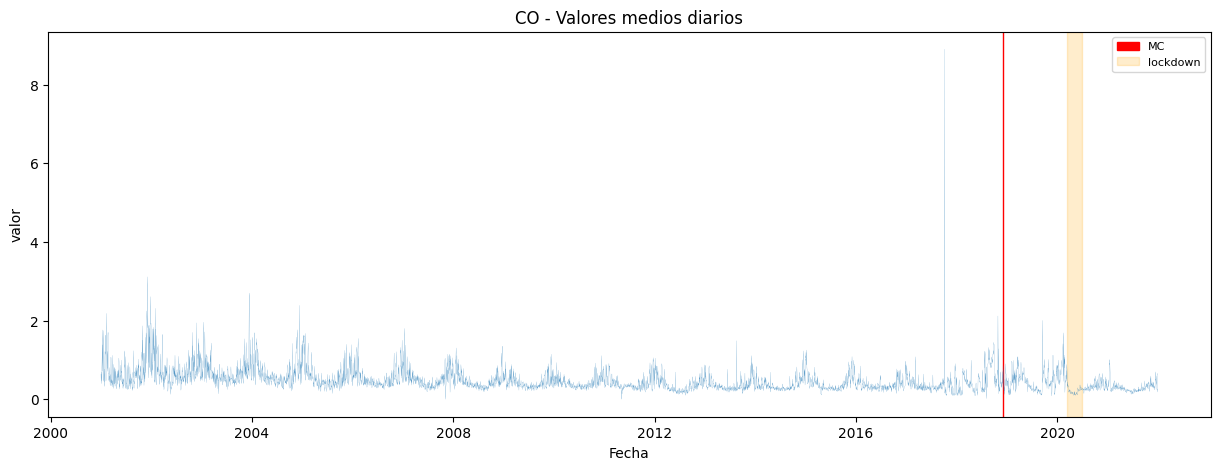

In [32]:
# Convierto el df en formato "largo" utilizando .melt 
df_grafica = df_co.melt(id_vars='fecha', value_vars=columnas_hora, var_name='hora', value_name='valor')

# Y lo ordeno por fecha y hora
df_grafica = df_grafica.sort_values(['fecha', 'hora'])
df_co_mean_day = df_grafica.groupby('fecha').mean(numeric_only=True)

# Creo el gráfico
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_co_mean_day.index, df_co_mean_day['valor'], linewidth=0.1)

# Extras
ax.axvspan('2018-11-30','2018-12-01', color='red', label='MC')
ax.axvspan('2020-03-11','2020-06-26', color='orange', alpha=0.2, label='lockdown')

# Textos, etiquetas y leyenda
ax.set_xlabel('Fecha')
ax.set_ylabel('valor')
ax.set_title('CO - Valores medios diarios')
ax.legend(fontsize=8)

# Mostrar el gráfico
plt.show()

### Estudio del efecto de las precipitaciones sobre las emisiones de estos gases


Esta variación puede deberse a un aumento/disminución de las precipitaciones en esos años. Por lo que, sería interesante analizar el efecto de las precipitaciones, para ello disponemos de las precipitaciones a lo largo de los años 2018 y 2019 en Madrid, en el fichero `historico.clima.xlsx`.

**¿Explica el comportamiento anual de las precipicationes la variación en los niveles de gases bajo estudio o podemos atribuir dicho efecto a la implementación de Madrid central?**

<span style="color:#FFD8A7 ">

Para analizar la posible correlación (no necesariamente causalidad) de las precipitaciones y las emisiones de gases, realizaría los siguientes pasos:  

1. Preparar datos:
- Cargar los datos de las precipitaciones diarias y las mediciones de gases en dos df separados.
- Ambos df con una columna de fecha para poder combinar los datos correctamente.
   
2. Agregar los datos:
- Si los datasets tienen una granularidad diaria, puedo agrupar los datos por semana, mes o año.
- Utilizar funciones de agregación, como la suma o media, para obtener un valor representativo de las precipitaciones y las emisiones de gases.  

3. Gráficas:
- Crea gráficos de dispersión (scatter plot en matplotlib) o diagramas de caja para visualizar la relación entre las precipitaciones y las emisiones de gases.
- Utiliza el eje x para representar las precipitaciones y el eje y para representar las emisiones de gases.
- Observar si hay alguna tendencia o patrón aparente en los datos.

4. Análisis estadístico:
- Calcular coeficientes de correlación (Pearson), para determinar la relación estadística entre precipitaciones y emisiones.
  
5. Modelado y predicción:
- Utilizar técnicas de modelado, como regresión lineal u otros modelos de ML, para predecir las emisiones en función de las precipitaciones.

</span>



In [33]:
# Preparo datos de precipitaciones
df_clima = pd.read_excel("historico-clima.xlsx", index_col=0)
df_clima = df_clima.sort_values("timestamp")

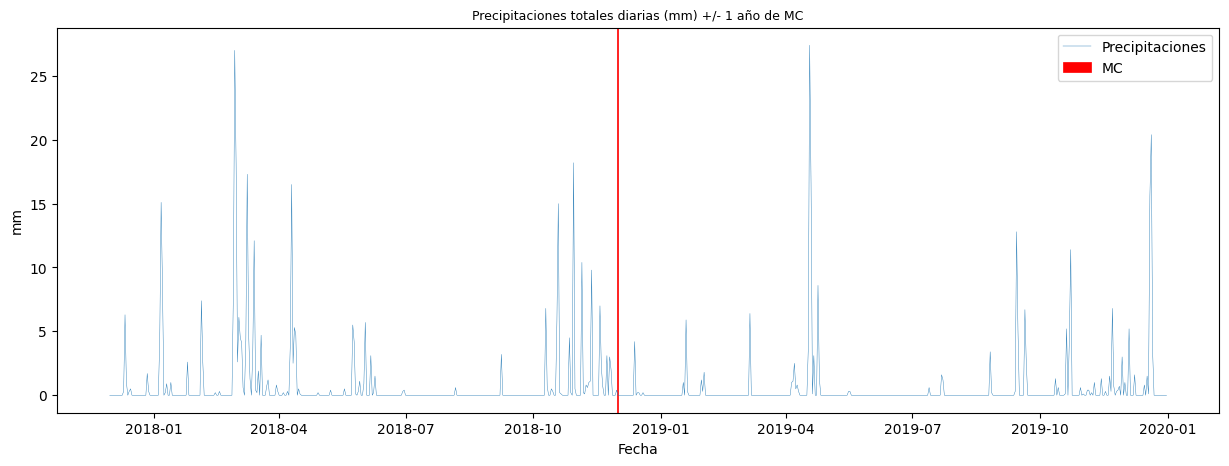

In [34]:
# Creo el gráfico de línea:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_clima['2017-11-30':'2019'], label='Precipitaciones',linewidth=0.3)
ax.axvspan('2018-11-30','2018-12-01', color='red', linewidth=0.5, label='MC')

# Etiquetas y título: 
ax.set_xlabel('Fecha')
ax.set_ylabel('mm')
ax.set_title('Precipitaciones totales diarias (mm) +/- 1 año de MC', fontsize='9')

# Leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

In [35]:
# Para ver si hay una correlación entre precipitaciones y emisiones voy a trabajar con estos df:
df_clima_day = df_clima
df_co_disp = df_co_mean_day
df_no2_disp = df_no2_mean_day

In [36]:
df_co_disp['co'] = df_co_disp['valor']
df_co_disp['no2'] = df_no2_disp['valor']
df_z = df_co_disp.drop(['valor'], axis=1)

In [37]:
df_z = pd.concat([df_z, df_clima_day], ignore_index=True, axis=1)
df_z = df_z.rename(columns={0:'co', 1:'no2', 2:'clima'})

In [38]:
# selecciono las fechas que tienen datos en todas las columnas
mask = (df_z.index > '2006-12-31') & (df_z.index <= '2017-12-31')
df_z = df_z.loc[mask]
df_z

,co,no2,clima
2007-01-01,0.420833,49.625000,0.0
2007-01-02,0.745833,74.541667,0.0
2007-01-03,1.229167,91.666667,0.0
2007-01-04,1.033333,90.875000,0.0
2007-01-05,0.854167,78.083333,0.0
...,...,...,...
2017-12-27,0.108333,32.625000,1.7
2017-12-28,0.145833,36.000000,0.3
2017-12-29,0.287500,38.250000,0.0
2017-12-30,0.541667,34.083333,0.0


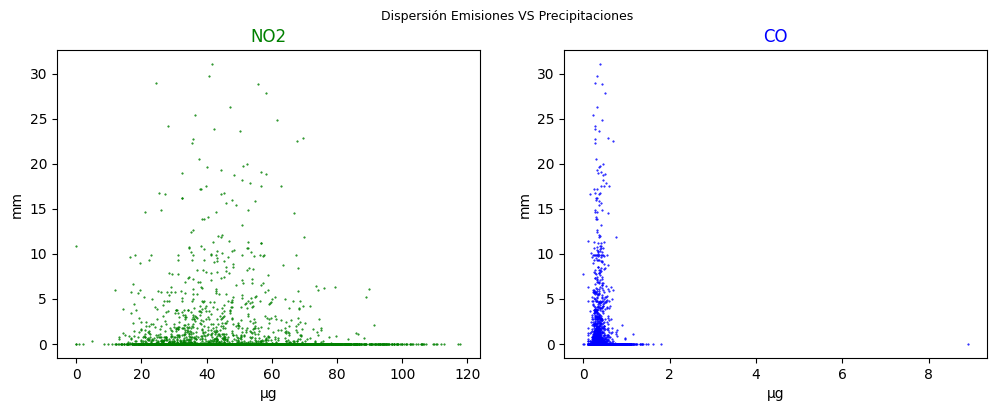

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 4))
fig.suptitle('Dispersión Emisiones VS Precipitaciones', fontsize='9')

ax1.scatter(df_z['no2'], df_z['clima'], marker=".", s=1, c="g")
ax2.scatter(df_z['co'], df_z['clima'], marker=".", s=1, c="blue")

# Etiquetas y título:
ax1.set_xlabel('μg') 
ax1.set_ylabel('mm')
ax1.set_title('NO2', c='g')

# Etiquetas y título: 
ax2.set_xlabel('μg')
ax2.set_ylabel('mm')
ax2.set_title('CO', c='b')

plt.show()

In [40]:
# Calculo los valores medios diarios de NO2 desde un año antes de MC (2017-11-30)
df_media_diaria = df_grafica.groupby('fecha').mean(numeric_only=True)
df_NO2_mean_18 = df_media_diaria['2017-11-30':'2019']

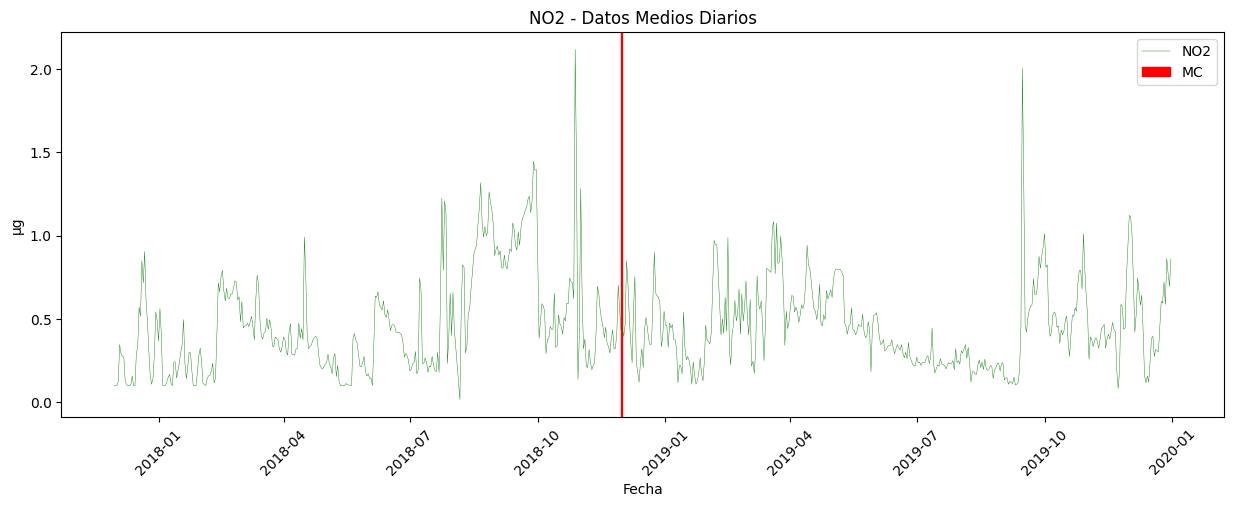

In [41]:
# Creo el gráfico de línea:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_NO2_mean_18.index, df_NO2_mean_18['valor'], color='green', label='NO2', linewidth=0.3)
ax.axvspan('2018-11-30','2018-12-01', color='red', label='MC')

# Etiquetas y título: 
ax.set_xlabel('Fecha')
ax.set_ylabel('μg')
ax.set_title('NO2 - Datos Medios Diarios')

# Etiquetas a 45º:
plt.xticks(rotation=45)

# Leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

### Modelado de los datos

¿Qué usos de Machine Learning verías aplicables a este conjunto de datos?

<span style="color:#FFD8A7 ">

- Predicción de calidad del aire en función de medidas históricas. Identificación de tendencias o patrones para anticiparse a condiciones futuras.
- Identificación de anomalías en tiempo real que puedan sugerir problemas de medición o eventos poco usuales que estén provocando mediciones no esperadas.
- Analizar distintas variables y su correlación con otros factores temporales o ambientales externos.
- Optimizar la cantidad y localización de las estaciones de medición en función de la representatividad de sus datos.
- Apoyo de investigación para estudios de correlación con parámetros de otros campos como por ejemplo, salud o transporte público.

</span>

¿Podrías usar uno de esos modelos de Machine Learning para **predecir las emisiones de NO2 durante la siguiente semana** al fin de los datos de tu dataset (agregado a nivel día)?

<span style="color:#FFD8A7 ">

Podría usar un modelo de Regresión Lineal Simple o un modelo Autoregressive Integrated Moving Average (ARIMA)

</span>